In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from itertools import product
import matplotlib.ticker as tkr  


def sizeof_fmt(x, pos):
  if x<0:
      return ""
  for x_unit in ['kB', 'MB', 'GB', 'TB']:
      if x < 1024.0:
          return "%3.1f %s" % (x, x_unit)
      x /= 1024.0

def cpuof_fmt(x, pos):
  return x /1000

sns.set_theme()

services =[ "celery",
            "geonode",
            "geoserver",
            "memcached",
            "nginx",
            "postgres",
            "pycsw",
            "rabbitmq"
]
stats = ["cpu","mem"]

def merge_mon_and_hist_df(df_base_hist, df_base_mon):

  MEMHELP =     lambda x: int(x.split("Ki")[0]) if "Ki" in x else (int(x.split("Mi")[0]) * 1024 if "Mi" in x else int(x.split("Gi")[0]) * 1024 * 1024)
  CPUHELP =     lambda x: float(x.split('n')[0]) / 1000 / 1000 if "n" in x else float(x.split('u')[0]) / 1000

  data = []

  last_r = {}
  for i,r in df_base_hist.iterrows():
      r = dict(r)
      for stat,service in product(stats, services):
          key = f"{service}_{stat}"
          df_base_hist[key] = df_base_hist['Timestamp'] * 0

          # break
          last_cpu = None
          last_mem = None
          try:
              r[key] = df_base_mon[(df_base_mon.name == service) & (df_base_mon['timestamp'] == r['Timestamp'])][stat].values[0]
              if stat == 'mem':
                  last_mem =  int(MEMHELP(r[key]))
                  #print(last_mem)
                  r[key] = last_mem
                  
              if stat == 'cpu':
                  last_cpu =  float(CPUHELP(r[key]))
                  r[key] = last_cpu
              
              last_r = dict(r)
          except:
              
              if key in last_r:
                r[key] = last_r[key]
              
      data.append(r)

  df = pd.DataFrame(data)
  df["total_cpu"] = df[[x for x in df.columns if "_cpu" in x]].sum(axis=1)
  df["total_mem"] = df[[x for x in df.columns if "_mem" in x]].sum(axis=1)
    
  # generate date
  df['date'] = pd.to_datetime(df['Timestamp'],unit='s')
  return df

In [51]:
import os

# open low3
folder_low = "low"
f_low_hist = "20241015143027.csv_stats_history.csv"
f_low_mon = "20241015143027-monitoring.log"
df_low_hist = pd.read_csv(os.path.join("./results",folder_low, f_low_hist), on_bad_lines="skip")
df_low_mon = pd.read_csv(os.path.join("./results/", folder_low ,f_low_mon), on_bad_lines="skip")
df_low_mon['date'] = pd.to_datetime(df_low_mon['timestamp'],unit='s')
df_low = merge_mon_and_hist_df(df_low_hist,df_low_mon)

# open base3
folder_base = "base"
f_base_hist = "20241015133515.csv_stats_history.csv"
f_base_mon = "20241015133515-monitoring.log"
df_base_hist = pd.read_csv(os.path.join("./results",folder_base, f_base_hist), on_bad_lines="skip")
df_base_mon = pd.read_csv(os.path.join("./results/", folder_base ,f_base_mon), on_bad_lines="skip")
df_base_mon['date'] = pd.to_datetime(df_base_mon['timestamp'],unit='s')
df_base = merge_mon_and_hist_df(df_base_hist,df_base_mon)

# open high2
folder_high = "high"
f_high_hist = "20241015151010.csv_stats_history.csv"
f_high_mon = "20241015151010-monitoring.log"
df_high_hist = pd.read_csv(os.path.join("./results",folder_high, f_high_hist), on_bad_lines="skip")
df_high_mon = pd.read_csv(os.path.join("./results/", folder_high ,f_high_mon), on_bad_lines="skip")
df_high_mon['date'] = pd.to_datetime(df_high_mon['timestamp'],unit='s')
df_high = merge_mon_and_hist_df(df_high_hist,df_high_mon)




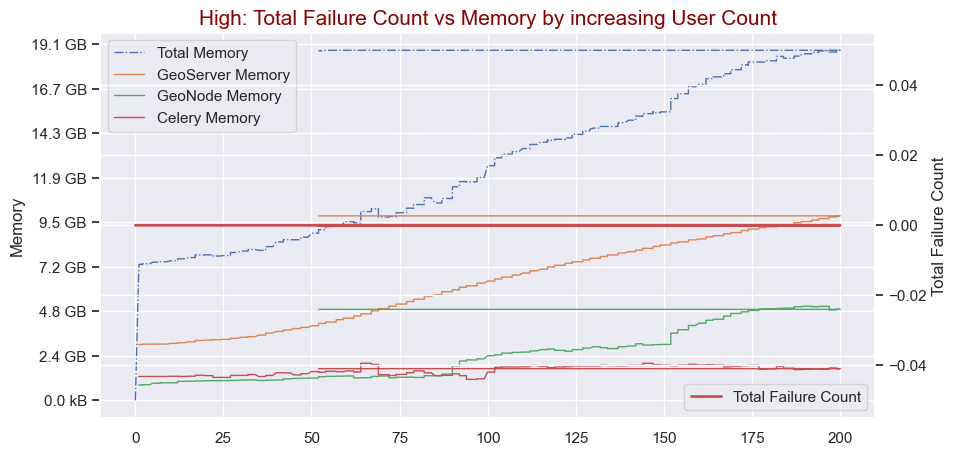

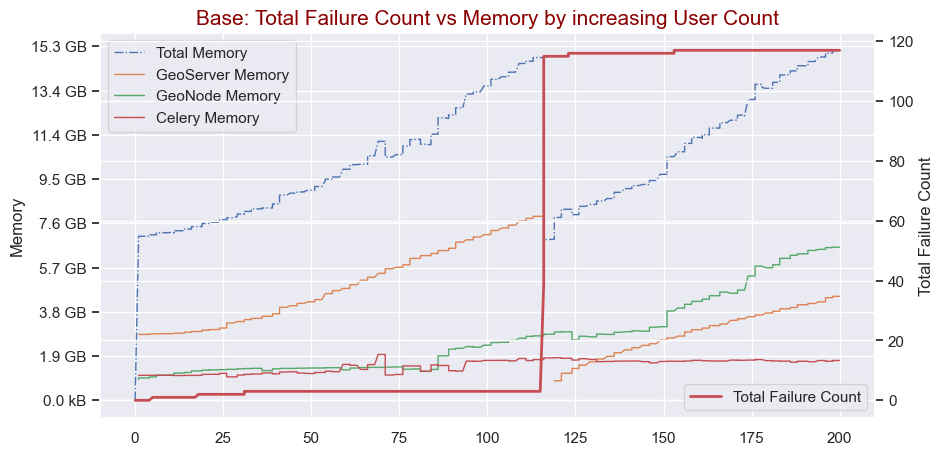

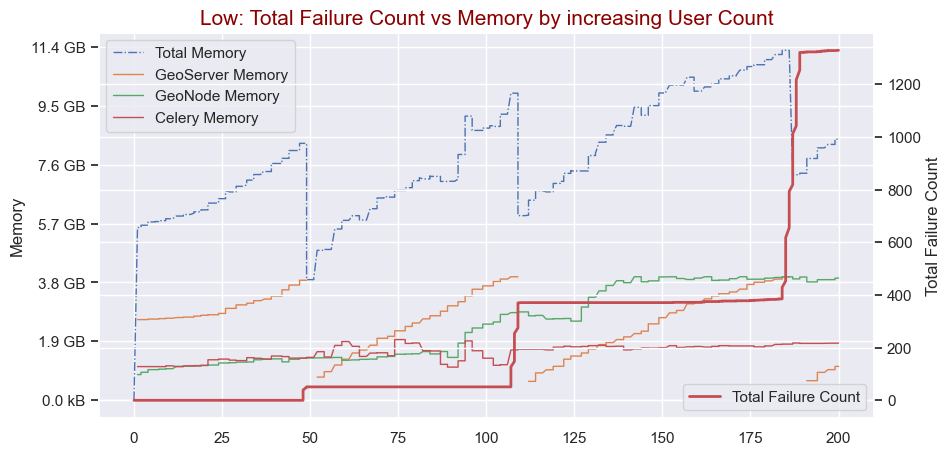

In [40]:

dataframes = {
    "High": df_high,
    "Base": df_base,
    "Low": df_low
}
for df_label, dataframe in dataframes.items():
  font = {"family": "sans-serif", "color": "darkred", "size": 15}
  fig, ax = plt.subplots(figsize=(10, 5))
  x = "User Count"

  ax.plot(
      x,
      "total_mem",
      data=dataframe,
      label="Total Memory",
      linestyle="-.",
      linewidth=1.0
  )
  ax.plot(
      x,
      "geoserver_mem",
      data=dataframe,
      label="GeoServer Memory",
      linewidth=1.0
  )
  ax.plot(
      x,
      "geonode_mem",
      data=dataframe,
      label="GeoNode Memory",
      linewidth=1.0
  )
  ax.plot(
      x,
      "celery_mem",
      data=dataframe,
      label="Celery Memory",
      linewidth=1.0
  )

  ax.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_fmt))
  ax.set_ylabel('Memory') 
  ax.legend(loc=('upper left'))


  ax2 = ax.twinx() 
  ax2.plot(
      x,
      "Total Failure Count",
      data=dataframe,
      label=f"Total Failure Count",
      color="r",
      linewidth=2.0
  )
  # ax2.plot(
  #     x,
  #     "Total Failure Count",
  #     data=df_high,
  #     label="HIGH: Failures/S",
  #     # linestyle="-.",
  # )
  ax2.set_ylabel('Total Failure Count') 
  ax2.legend(loc=('lower right'))

  plt.xlabel("User Count")
  plt.title(f"{df_label}: Total Failure Count vs Memory by increasing User Count", fontdict=font)
  plt.savefig(f"results/plots/{df_label}_total_failures_vs_memory.png")



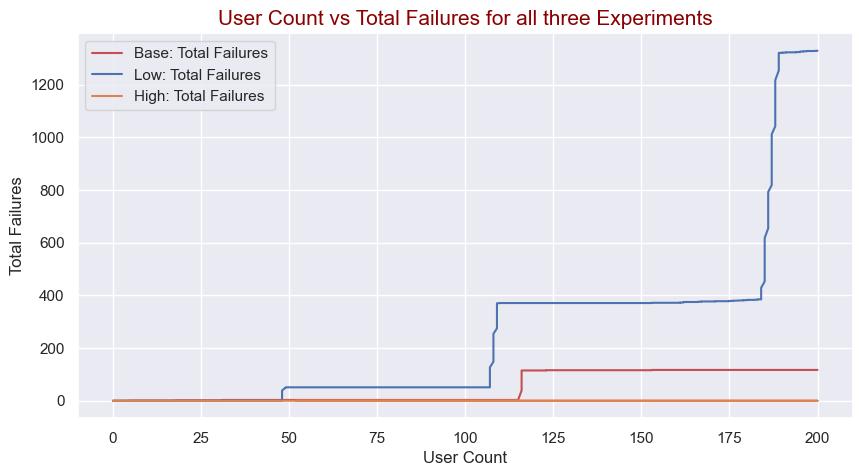

In [46]:

x = "User Count"
y = "Total Failure Count"
y_label = "Total Failures"
font = {"family": "sans-serif", "color": "darkred", "size": 15}
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    x,
    y,
    data=df_base,
    label=f"Base: {y_label}",
    color="r"
    # linestyle="-.",
)
ax.plot(
    x,
    y,
    data=df_low,
    label=f"Low: {y_label}",
    # linestyle="-.",
)

ax.plot(
    x,
    y,
    data=df_high,
    label=f"High: {y_label}",
    # linestyle="-.",
)
ax.set_ylabel("{y_label}") 
ax.legend()

#ax.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_fmt))
ax.set_ylabel('Total Failures') 
ax.legend(loc=('upper left'))

plt.xlabel("User Count")
plt.title("User Count vs Total Failures for all three Experiments", fontdict=font)
plt.savefig(f"results/plots/total_failures_for_all_experiments.png")



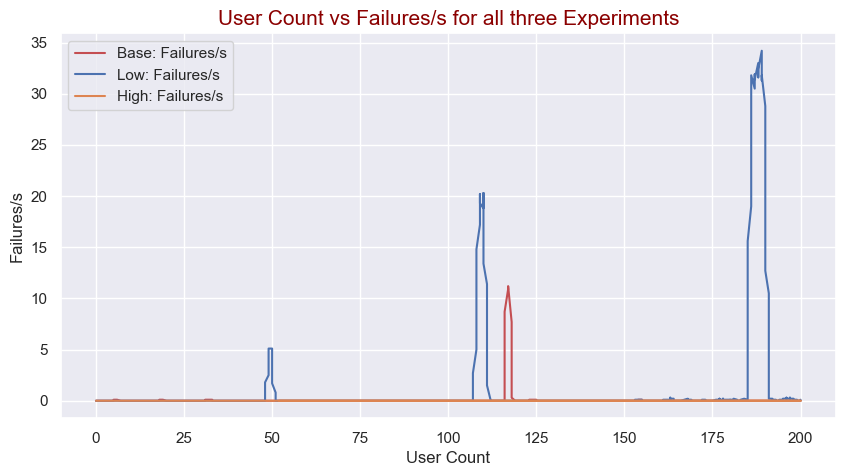

In [47]:

x = "User Count"
y = "Failures/s"
y_label = "Failures/s"
font = {"family": "sans-serif", "color": "darkred", "size": 15}
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    x,
    y,
    data=df_base,
    label=f"Base: {y_label}",
    color="r"
    # linestyle="-.",
)
ax.plot(
    x,
    y,
    data=df_low,
    label=f"Low: {y_label}",
    # linestyle="-.",
)

ax.plot(
    x,
    y,
    data=df_high,
    label=f"High: {y_label}",
    # linestyle="-.",
)
ax.set_ylabel("{y_label}") 
ax.legend()

#ax.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_fmt))
ax.set_ylabel('Failures/s') 
ax.legend(loc=('upper left'))

plt.xlabel("User Count")
plt.title("User Count vs Failures/s for all three Experiments", fontdict=font)
plt.savefig(f"results/plots/failures_s_for_all_experiments.png")



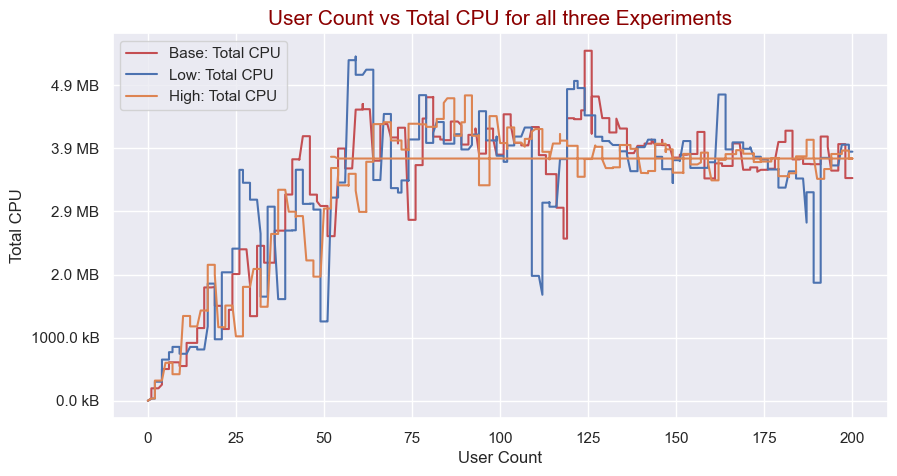

In [49]:
x = "User Count"
y = "total_cpu"
y_label = "Total CPU"
font = {"family": "sans-serif", "color": "darkred", "size": 15}
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(
    x,
    y,
    data=df_base,
    label=f"Base: {y_label}",
    color="r"
    # linestyle="-.",
)
ax.plot(
    x,
    y,
    data=df_low,
    label=f"Low: {y_label}",
    # linestyle="-.",
)

ax.plot(
    x,
    y,
    data=df_high,
    label=f"High: {y_label}",
    # linestyle="-.",
)
ax.yaxis.set_major_formatter(tkr.FuncFormatter(cpuof_fmt))

ax.set_ylabel("{y_label}") 
ax.legend()

#ax.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_fmt))
ax.set_ylabel('Total CPU') 
ax.legend(loc=('upper left'))

plt.xlabel("User Count")
plt.title("User Count vs Total CPU for all three Experiments", fontdict=font)
plt.savefig(f"results/plots/total_cpu_for_all_experiments.png")

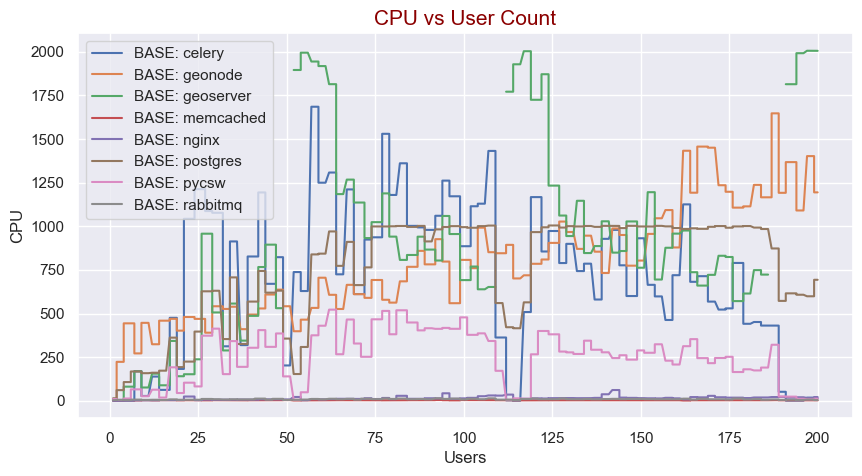

In [21]:
font = {"family": "sans-serif", "color": "darkred", "size": 15}
fig, ax = plt.subplots(figsize=(10, 5))

for service in services:  
  ax.plot(
      "User Count",
      f"{service}_cpu",
      data=df_low,
      label=f"BASE: {service}",
      # linestyle="-.",
  )

plt.xlabel("Users")
plt.ylabel("CPU")
plt.title("CPU vs User Count", fontdict=font)
leg = ax.legend()

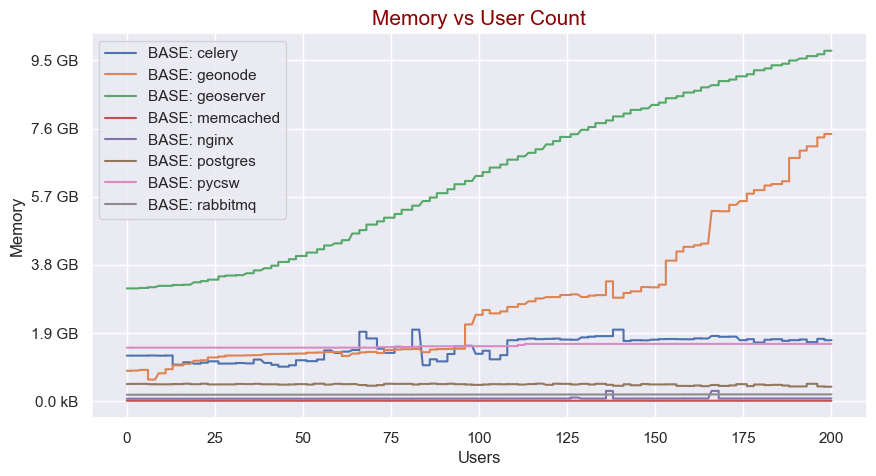

In [10]:
font = {"family": "sans-serif", "color": "darkred", "size": 15}
fig, ax = plt.subplots(figsize=(10, 5))

for service in services:  
  ax.plot(
      "User Count",
      f"{service}_mem",
      data=df_high,
      label=f"BASE: {service}",
      # linestyle="-.",
  )
ax.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_fmt))

plt.xlabel("Users")
plt.ylabel("Memory")
plt.title("Memory vs User Count", fontdict=font)
leg = ax.legend()

<Axes: xlabel='Timestamp', ylabel='Total Request Count'>

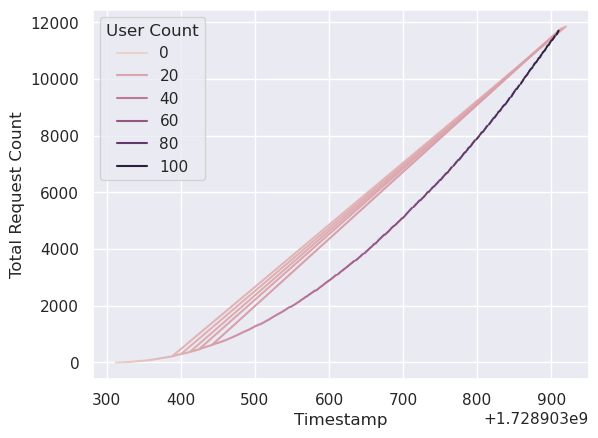

In [ ]:
#agregated by user
sns.lineplot(data=df_hist, x="Timestamp", y="Total Request Count", hue="User Count")

In [ ]:
# user1 = df_hist.query("User Count == '1,'")
# user1.plot(x="Timestamp",y="User Count")

In [ ]:
# col = 'A'
# df2 = df.drop(col,axis=1)
# df2.index = df[col]
# df2.plot(subplots=True, style='.')
# plt.legend(loc='best')
# plt.show()